# **MODELO DE MACHINE LEARNING**
## _Cosine Similarity_

Aquí se muestran los pasos seguidos para construir un modelo de recomendación de juegos basado en la similitud del coseno.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np

Importamos el dataset que contiene los datos necesarios para elaborar un modelo de predicción

In [2]:
output=pd.read_csv('output90p.csv')


def recomendacion_juego( id de producto ): Ingresando el id de producto, deberíamos recibir una lista con 5 juegos recomendados similares al ingresado.

El data frame output contiene generos, id de producto y nombre de producto

In [3]:
output.head()

,Unnamed: 0,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,year
0,0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,0.0,761140,Kotoshiro,2018
1,1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,0.0,643980,Secret Level SRL,2018
2,2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,0.0,670290,Poolians.com,2017
3,3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,0.0,767400,彼岸领域,2017
4,4,NaN,"['Action', 'Casual', 'Indie', 'Sports']",Log Challenge,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,0.0,773570,NaN,2014


Realizamos una limpieza extra y reiniciamos los índices.

In [4]:
outml=output[['genres','title', 'id']]
outml.dropna(subset=['genres'], inplace=True)
outml = outml[outml['genres'].apply(lambda x: len(x) > 0)]
outml.reset_index(drop=True, inplace=True)


C:\Users\Owner\AppData\Local\Temp\ipykernel_20232\2301122584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outml.dropna(subset=['genres'], inplace=True)


In [5]:
outml 

,genres,title,id
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,761140
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,643980
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,670290
3,"['Action', 'Adventure', 'Casual']",弹炸人2222,767400
4,"['Action', 'Casual', 'Indie', 'Sports']",Log Challenge,773570
...,...,...,...
31940,"['Casual', 'Indie', 'Simulation', 'Strategy']",Colony On Mars,773640
31941,"['Casual', 'Indie', 'Strategy']",LOGistICAL: South Africa,733530
31942,"['Indie', 'Racing', 'Simulation']",Russian Roads,610660
31943,"['Casual', 'Indie']",EXIT 2 - Directions,658870


## Desarrollo del modelo utilizando la funcion _cosine similarity_

Para aplicar la función de similitud del coseno, vamos a tomar las cadenas dentro de cada lista de generos, las vamos a separar y posteriormente contabilizar los caracteres, para de esa manera poder realizar una comparación.

En este paso se toma un set para entrenamiento y otro para prueba en un ratio de 80/20

Finalmente se tiene el calculo de una función global que contiene los scores para cada id


In [6]:

outml.dropna(subset=['genres'], inplace=True)
outml = outml[outml['genres'].apply(lambda x: len(x) > 0)]

# Esta sección se centra en la limpieza de datos. Elimina las filas con valores faltantes en la columna 'genres' y asegura que las listas en 'genres' tengan una longitud mayor que 0.
outml['genres_str'] = outml['genres'].apply(lambda x: ' '.join(re.sub(r'\W', ' ', str(e)) for e in x))

#manejo de posibles valores NaN
outml['genres_str'].fillna('', inplace=True)

# Crear un CountVectorizer para contar términos
vectorizer = CountVectorizer(tokenizer=lambda x: re.findall('\w+', x), max_features=1000)

# Aplicar el CountVectorizer a 'genres_str' y obtener la matriz de términos
term_matrix = vectorizer.fit_transform(outml['genres_str']).toarray()

# Crear un DataFrame a partir de la matriz de términos
term_df = pd.DataFrame(term_matrix, columns=vectorizer.get_feature_names_out())


outml = pd.concat([outml, term_df], axis=1)

# Define una variable 'features' que contiene los nombres de las columnas de las características binarias. Estas columnas se utilizarán para calcular la similitud del coseno.
features = term_df.columns

# Divide el conjunto de datos en conjuntos de entrenamiento y prueba utilizando una proporción de 80-20 y una semilla aleatoria para reproducibilidad.
train_data, test_data = train_test_split(outml, test_size=0.2, random_state=42)


train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)


cosine_sim_train = cosine_similarity(train_data[features], train_data[features])

#Calcula las matrices de similitud del coseno para los conjuntos de entrenamiento y prueba basándose en las características seleccionadas.
cosine_sim_test = cosine_similarity(test_data[features], test_data[features])


print("Tamaño de matriz entrenamiento:", cosine_sim_train.shape)
print("Tamaño de matriz prueba:", cosine_sim_test.shape)

#Calcula la matriz de similitud del coseno para todo el conjunto de datos basándose en las características seleccionadas y imprime su forma.
cosine_sim_full = cosine_similarity(outml[features], outml[features])


print("Tamaño de matriz para el dataset:", cosine_sim_full.shape)

c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Tamaño de matriz entrenamiento: (25556, 25556)
Tamaño de matriz prueba: (6389, 6389)
Tamaño de matriz para el dataset: (31945, 31945)


Revisamos cómo quedó el dataframe con la contabilización de caracteres.

In [7]:
outml.head()

,genres,title,id,genres_str,a,b,c,d,e,f,...,n,o,p,r,s,t,u,v,w,y
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,761140,A c t i o n C a s u a l I ...,5,0,2,1,2,0,...,3,2,0,1,3,4,2,0,0,1
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,643980,F r e e t o P l a y I n d i e ...,2,0,0,1,4,1,...,1,1,2,3,1,3,0,0,0,2
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,670290,C a s u a l F r e e t o P l a ...,4,0,1,1,3,1,...,2,3,2,2,4,3,2,0,0,1
3,"['Action', 'Adventure', 'Casual']",弹炸人2222,767400,A c t i o n A d v e n t u r e ...,4,0,2,1,2,0,...,2,1,0,1,1,2,2,1,0,0
4,"['Action', 'Casual', 'Indie', 'Sports']",Log Challenge,773570,A c t i o n C a s u a l I ...,3,0,2,1,1,0,...,2,2,1,1,3,2,1,0,0,0


Revisamos la matriz de similitud de cosenos

In [8]:
cosine_sim_full

array([[1.        , 0.71719808, 0.92539531, ..., 0.88941012, 0.86558389,
        0.94376324],
       [0.71719808, 1.        , 0.79372539, ..., 0.60861167, 0.53333333,
        0.76104942],
       [0.92539531, 0.79372539, 1.        , ..., 0.79466149, 0.80632421,
        0.91226029],
       ...,
       [0.88941012, 0.60861167, 0.79466149, ..., 1.        , 0.84836778,
        0.8662134 ],
       [0.86558389, 0.53333333, 0.80632421, ..., 0.84836778, 1.        ,
        0.89151503],
       [0.94376324, 0.76104942, 0.91226029, ..., 0.8662134 , 0.89151503,
        1.        ]])

También podemos revisarla de forma gráfica, los colores más encendidos indican mayor similitud, el grado de similitud va de -1 a 1, siendo 1 completamente similar y -1 completamente distinto

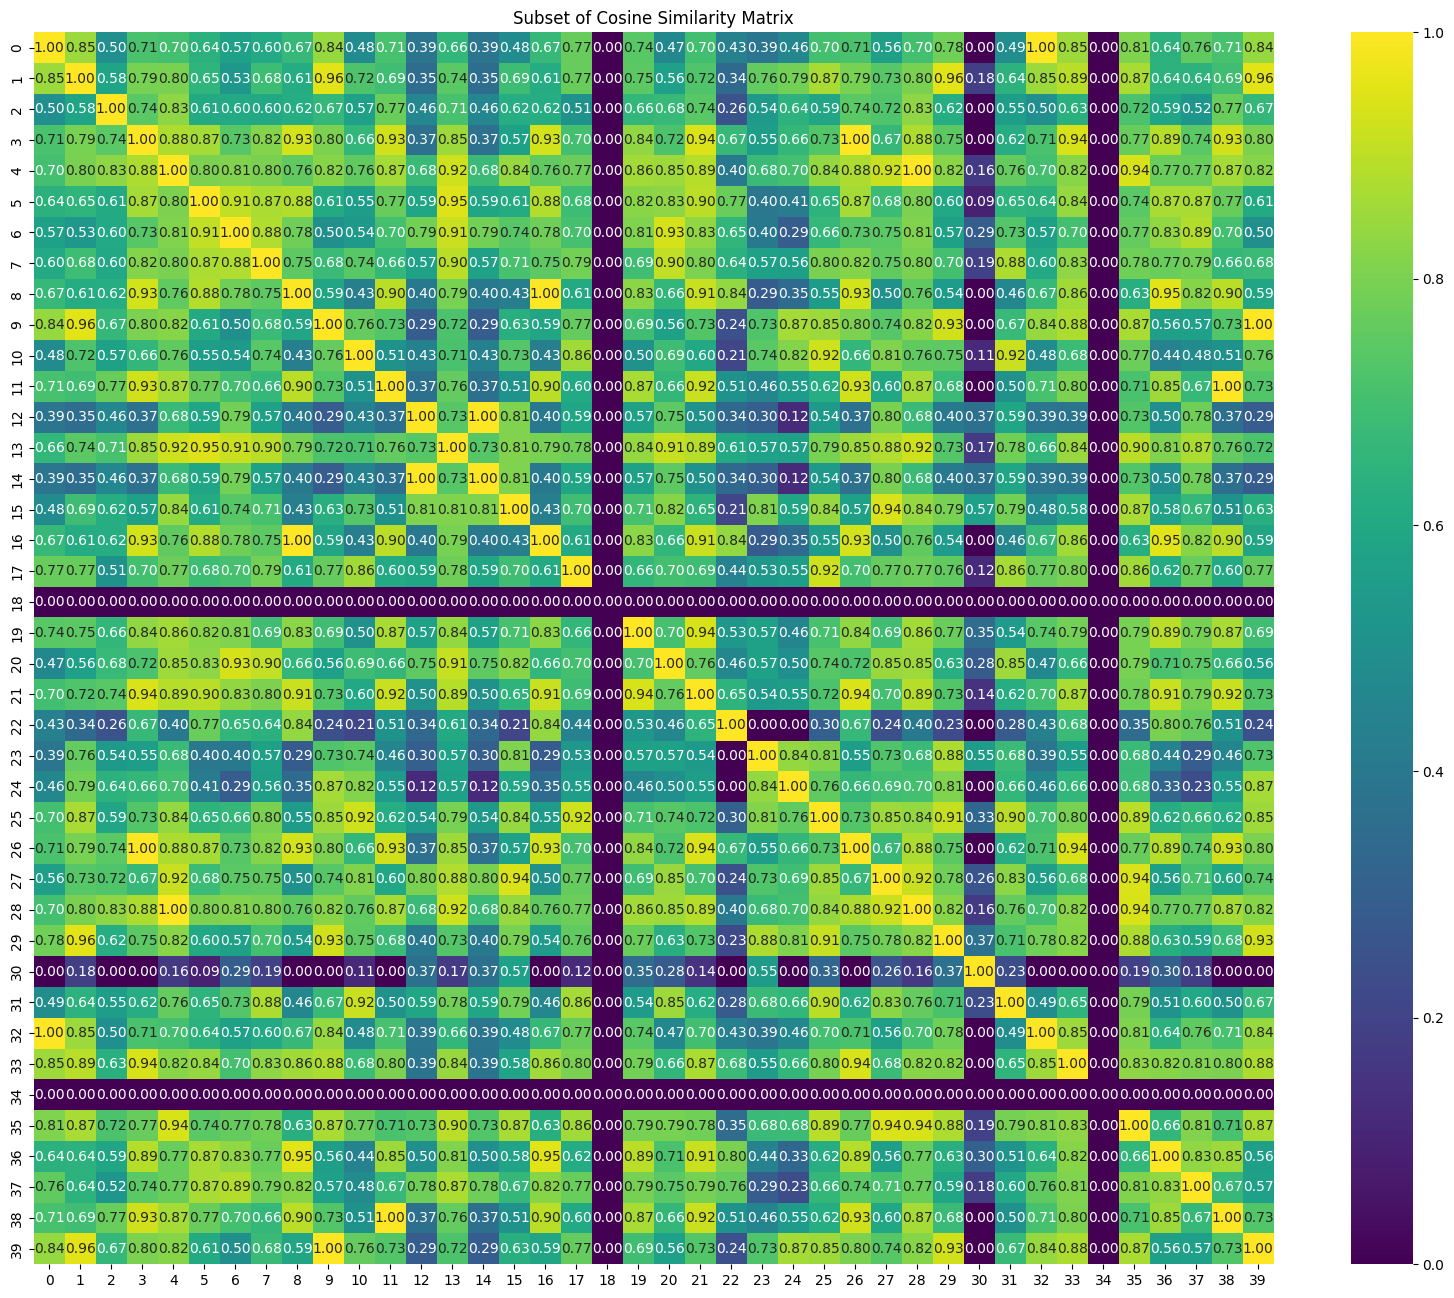

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample a subset of rows and columns
subset_indices = np.random.choice(cosine_sim_full.shape[0], size=40, replace=False)
subset_cosine_sim = cosine_sim_full[subset_indices][:, subset_indices]

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(subset_cosine_sim, cmap="viridis", annot=True, fmt=".2f")
plt.title("Subset of Cosine Similarity Matrix")
plt.show()

#### Verificación Final

A modo de verificación final, creamos una función que genere un data frame con las recomendaciones y sus respectivos generos para hacer una comparación visual:

In [10]:
def get_similar_titles_and_genres(title_id):
    # Get the index of the title based on its ID
    indices = outml.index[outml['id'] == title_id].tolist()

    # Check if any matching indices were found
    if not indices:
        print(f"No matching index found for title ID: {title_id}")
        return pd.DataFrame()  # Return an empty DataFrame

    # Take the first index if there are multiple matches
    index = indices[0]

    # Get the cosine similarity scores for the title
    sim_scores = list(enumerate(cosine_sim_full[index]))

    # Sort the titles based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top 6 (including itself) most similar titles
    top_indices = [i[0] for i in sim_scores[1:20]]

    # Extract title and genre information and return as a DataFrame
    similar_titles_and_genres = outml.loc[top_indices, ['id', 'title', 'genres']]
    
    return similar_titles_and_genres

Podemos observar que los titulos sugeridos cumplen con tener similitud en generos

In [12]:
get_similar_titles_and_genres(10)

,id,title,genres
32,690410,Twisted Enhanced Edition,['Action']
55,3800,Advent Rising,['Action']
78,6550,Devil May Cry® 3 Special Edition,['Action']
80,2290,Final DOOM,['Action']
83,2280,Ultimate Doom,['Action']
84,9160,Master Levels for Doom II,['Action']
85,2300,DOOM II,['Action']
86,2270,Wolfenstein 3D,['Action']
87,9010,Return to Castle Wolfenstein,['Action']
88,9040,QUAKE Mission Pack 1: Scourge of Armagon,['Action']


### Desarrollo de la función de extracción de top 5

La funcion get_similar_titles genera una lista de los 5 titulos con mayor score de similitud segun la matriz.

In [13]:
def get_similar_titles(title_id):
    # Get the index of the title based on its ID
    indices = outml.index[outml['id'] == title_id].tolist()

    # Check if any matching indices were found
    if not indices:
        print(f"No matching index found for title ID: {title_id}")
        return []

    # Take the first index if there are multiple matches
    index = indices[0]

    # Get the cosine similarity scores for the title
    sim_scores = list(enumerate(cosine_sim_full[index]))

    # Sort the titles based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top 6 (including itself) most similar titles
    top_indices = [i[0] for i in sim_scores[1:6]]

    # Extract title information and return as a flat list of strings
    similar_titles = outml.loc[top_indices, 'title'].tolist()

    return similar_titles
    


Probamos la función

In [14]:
get_similar_titles(767400)

['Atomic Adam: Episode 1',
 'Biozone',
 'Luxor: 5th Passage',
 'DuckTales: Remastered',
 'Scooby Doo! &amp; Looney Tunes Cartoon Universe: Adventure']

Creamos un dataframe df_recommendations para agregarle las recomendaciones.

In [15]:
df_recommendation=outml[['id']]

Utilizando el dataframe df_recommendation creado previamente agregamos una columna con la lista de titulos sugeridos para cada id, de manera que en los siguientes procesos podamos hacer las consultas directamente a este data frame

In [16]:
df_recommendation['recommendations'] = df_recommendation['id'].apply(get_similar_titles)

C:\Users\Owner\AppData\Local\Temp\ipykernel_20232\4107614549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recommendation['recommendations'] = df_recommendation['id'].apply(get_similar_titles)


Revisamos nuestro data frame

In [17]:
df_recommendation

,id,recommendations
0,761140,"[Pixel Puzzles 2: Anime, World of Cinema - Dir..."
1,643980,"[Shadow Hunter, Immortal Empire, Immortal Empi..."
2,670290,"[Snooker-online multiplayer snooker game!, Mal..."
3,767400,"[Atomic Adam: Episode 1, Biozone, Luxor: 5th P..."
4,773570,"[Canyon Capers - Rio Fever, Lighthockey, 12 or..."
...,...,...
31940,773640,"[Fate of the World: Tipping Point, Fate of the..."
31941,733530,"[Puzzler World 2, iBomber Defense Pacific, Bum..."
31942,610660,"[Try Hard Parking, Car Mechanic Simulator 2015..."
31943,658870,"[Zen of Sudoku, Gumboy - Crazy Adventures™, RI..."


In [18]:
df_recommendation.to_parquet('recommendation.parquet')

In [19]:
df_recommendation=pd.read_parquet('recommendation.parquet')

### Desarrollo de la función de consulta final

In [76]:
def recomendacion_juego(id):
    df_recommendation = pd.read_parquet('recommendation.parquet')
    
    # Verifica si el id está en el DataFrame
    if id in df_recommendation['id'].values:
        # Recoge las recomendaciones como una cadena
        recommendations_array = df_recommendation.loc[df_recommendation['id'] == id, 'recommendations'].iloc[0]

        # Se observo que el resultado es un array asi que convertimos el array de NumPy a una lista de Python
        recommendations_list = list(np.asarray(recommendations_array))

        return recommendations_list
    else:
        # Si el id no está presente, muestra el siguiente mensaje
        return f"No se encontraron recomendaciones para ID {id}"

In [77]:
recomendacion_juego(10)


['Twisted Enhanced Edition',
 'Advent Rising',
 'Devil May Cry® 3 Special Edition',
 'Final DOOM',
 'Ultimate Doom']